In [1]:
import os
import numpy as np
import tensorflow as tf
import scipy.io as sio
from scipy.stats import beta
from tensorflow.random import set_seed
from scipy.stats import gaussian_kde as kde
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
#######################################
#define the activation function
def rbf(x):
    return tf.math.exp(-x**2)

#######################################
#define the derivative of the activation function
def d_rbf(x):
    return tf.gradients(rbf,x)

#######################a################
#we couldn't use “tf_d_leaky_relu_6” as an activation function if we wanted to 
#because tensorflow doesn't know how to calculate the gradients of that function.
def rbf_grad(op, grad):
    x = op.inputs[0]
    n_gr = d_rbf(x)    #defining the gradient.
    return grad * n_gr

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+2))
    tf.RegisterGradient(rnd_name)(grad)
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name, "PyFuncStateless": rnd_name}):
#     with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def tf_rbf(x,name=None):
    with tf.name_scope(name, "rbf", [x]) as name:
        y = py_func(rbf,   #forward pass function
                    [x],
                    [tf.float32],
                    name=name,
                    grad= rbf_grad) #the function that overrides gradient
        y[0].set_shape(x.get_shape())     #when using with the code, it is used to specify the rank of the input.
    return y[0]

In [3]:
#### To make it cleaner, create Directory "images" to store all the figures ####
imagepath = os.path.join(os.getcwd(),"images")
os.makedirs(imagepath,exist_ok=True)

## 6.1 Feature Scaling and Data Preprocessing

In [4]:
a = 40
np.random.seed(12345)
listex = np.linspace(-a,a,100)
listey = listex**2 + 0.1*np.random.normal(0, 1, len(listex)) 

set_seed(12345)
model_rbf = tf.keras.Sequential()
model_rbf.add(tf.keras.layers.Dense(5,activation=rbf))
model_rbf.add(tf.keras.layers.Dense(1))
model_rbf.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.1))
model_rbf.fit(listex,listey, epochs=1000, verbose=0)

In [5]:
preds_rbf = []
size = 100
for j in np.linspace(-a,a,size):
    preds_rbf.append(model_rbf.predict([j]))

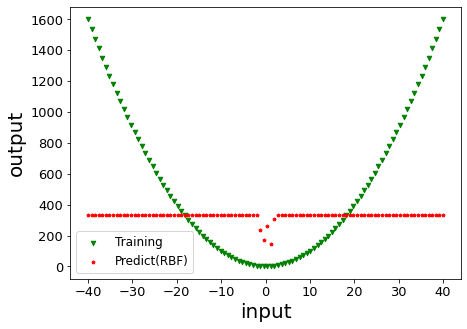

In [6]:
fig = plt.figure(figsize=(7,5))
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel('input',fontsize=20)
plt.ylabel("output",fontsize=20)
plt.scatter(listex, listey, s=20, marker='v',color='g', label="Training")     #size of point
plt.scatter(np.linspace(-a,a,size), np.array(preds_rbf), s=10, marker='p', color='r', label="Predict(RBF)")
plt.legend(prop={'size': 12});
# fig.savefig("images/NN_before_scale.png");

In [7]:
data = np.array((listex,listey)).T
scaler = MinMaxScaler((-1,1))
data_trans = scaler.fit_transform(data)
xmax, ymax = scaler.data_max_
xmin, ymin = scaler.data_min_

In [8]:
set_seed(12345)
model_rbf2 = tf.keras.Sequential()
model_rbf2.add(tf.keras.layers.Dense(5,activation=rbf))
model_rbf2.add(tf.keras.layers.Dense(1))
model_rbf2.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.1))
model_rbf2.fit(data_trans[:,0],data_trans[:,1],epochs=1000, verbose=0)

In [9]:
x_test = np.linspace(xmin,xmax,100).reshape(-1,1)
scaler = MinMaxScaler((-1,1))
x_test_trans = scaler.fit_transform(x_test) 
preds_rbf_trans = model_rbf2.predict(x_test_trans)
preds_rbf2 = (preds_rbf_trans+1)*(ymax-ymin)/2+ymin

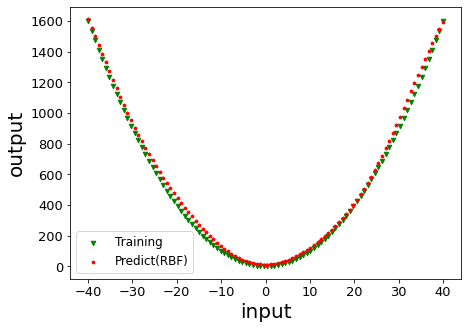

In [10]:
fig = plt.figure(figsize=(7,5))
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel('input',fontsize=20)
plt.ylabel("output",fontsize=20)
plt.scatter(listex, listey, s=20, marker='v',color='g', label="Training")     #size of point
plt.scatter(x_test, preds_rbf2, s=10, marker='p', color='r', label="Predict(RBF)")
plt.legend(prop={'size': 12});
# fig.savefig("images/NN_after_scale.png");

## 6.2 Architecture of the hidden layers

In [11]:
np.random.seed(12345)
x_act = np.pi*np.linspace(-1,1,200)
y_act = np.sin(x_act)+0.1*np.random.normal(0,1,len(x_act))
# listex3 = np.linspace(-1,1,100)
# listey3 = 1/(1+listex3**2)

In [12]:
## RBF ##
set_seed(12345)
model_rbf_act = tf.keras.Sequential()
model_rbf_act.add(tf.keras.layers.Dense(5,activation=rbf))
model_rbf_act.add(tf.keras.layers.Dense(1))
model_rbf_act.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.1))
model_rbf_act.fit(x_act,y_act, epochs=1000, verbose=0)

## ReLU ##
set_seed(12345)
model_relu_act = tf.keras.Sequential()
model_relu_act.add(tf.keras.layers.Dense(5,activation='relu'))
model_relu_act.add(tf.keras.layers.Dense(1))
model_relu_act.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.1))   #0.01:0.00333
model_relu_act.fit(x_act,y_act, epochs=1000, verbose=0)

## sigmoid ##
set_seed(12345)
model_sig_act = tf.keras.Sequential()
model_sig_act.add(tf.keras.layers.Dense(5,activation='sigmoid'))
model_sig_act.add(tf.keras.layers.Dense(1))
model_sig_act.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.1))
model_sig_act.fit(x_act,y_act, epochs=1000, verbose=0)

In [13]:
preds_rbf_act = []
preds_relu_act = []
preds_sig_act = []
size = 100
x_eval_act = np.pi*np.linspace(-1,1,size)
for j in x_eval_act:
    preds_rbf_act.append(model_rbf_act.predict([j]))
    preds_relu_act.append(model_relu_act.predict([j]))
    preds_sig_act.append(model_sig_act.predict([j]))

In [14]:
## RBF ##
p1 = tf.reshape(tf.constant(preds_rbf_act),len(preds_rbf_act))
error1 = tf.keras.losses.MSE(np.sin(x_eval_act),p1).numpy()

## ReLU ##
p2 = tf.reshape(tf.constant(preds_relu_act),len(preds_relu_act))
error2 = tf.keras.losses.MSE(np.sin(x_eval_act),p2).numpy()

## sigmoid ##
p3 = tf.reshape(tf.constant(preds_sig_act),len(preds_sig_act))
error3 = tf.keras.losses.MSE(np.sin(x_eval_act),p3).numpy()

print(error1, error2, error3)

0.0061783562 0.0069011813 0.0023731478


### Activated neurons

Target function - (1)

$$
y = x^2
$$

##### Activation: ReLU

In [15]:
a = 40
np.random.seed(12345)
x_on1 = np.linspace(-1,1,100)
y_on1 = x_on1**2 + 0.1*np.random.normal(0, 1, len(x_on1)) 

num_neuron = 5
set_seed(12345)
model_relu_on = tf.keras.Sequential()
model_relu_on.add(tf.keras.layers.Dense(num_neuron,activation='relu'))
model_relu_on.add(tf.keras.layers.Dense(1))
model_relu_on.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_relu_on.fit(x_on1,y_on1, epochs=1500, verbose=0)


weight_relu_on = model_relu_on.get_weights()
bdry_relu_on = []
bdry1_relu_on = []
for i in range(weight_relu_on[0].shape[1]):
    val = -weight_relu_on[1][i]/weight_relu_on[0][0,i]
    if weight_relu_on[0][0,i] >0:
        bdry_relu_on.append((val,i))    
        bdry1_relu_on.append((val,i,'left'))     # left flat
    else:
        bdry_relu_on.append((val,i))   
        bdry1_relu_on.append((val,i,'right'))
        
bdry_arr_relu_on = np.array(sorted(bdry_relu_on))

def piece(weight,i,x):
    b1 = weight[1][i]
    w1 = weight[0][0,i]
    val = tf.keras.activations.relu(w1*x+b1).numpy()
    return (weight[2][i])*val

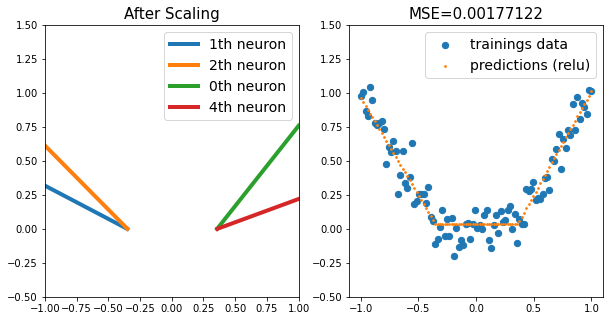

In [16]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
x_rb = 1
x_lb = -1
for i in map(int,bdry_arr_relu_on[:,1]):
    if bdry1_relu_on[i][-1] == 'left' and bdry1_relu_on[i][0]<x_rb: 
        x = np.linspace(bdry1_relu_on[i][0],x_rb,20)
        plt.plot(x, [piece(weight_relu_on,i,val) for val in x], label=str(i)+'th neuron', linewidth=4)
    elif bdry1_relu_on[i][-1] == 'right' and bdry1_relu_on[i][0]>x_lb:
        x = np.linspace(x_lb,bdry1_relu_on[i][0],20)
        plt.plot(x, [piece(weight_relu_on,i,val) for val in x], label=str(i)+'th neuron', linewidth=4)

plt.xlim(-1,1)
plt.ylim(-0.5,1.5)
plt.title('After Scaling',fontsize=15)
plt.legend(prop={'size': 14});
        
plt.subplot(122)
preds_relu_on = []
size = 100
for j in np.linspace(-1,1,size):
    preds_relu_on.append(model_relu_on.predict([j]))
p = tf.reshape(tf.constant(preds_relu_on),len(preds_relu_on))
error = tf.keras.losses.MSE(x_on1**2,p).numpy()
plt.ylim(-0.5,1.5)
plt.title('MSE=%.8f'%(error),fontsize=15)
plt.scatter(x_on1, y_on1, s=40, label="trainings data")     #size of point
plt.scatter(np.linspace(-1,1,size), np.array(preds_relu_on), s=3, label="predictions (relu)")
plt.legend(prop={'size': 14});
# fig.savefig("images/NN_Neurons_on_relu.png")

Target function - (1)

$$
y = x^2
$$

##### Activation: RBF

In [17]:
num_neuron = 5

set_seed(12345)
model_rbf_on = tf.keras.Sequential()
model_rbf_on.add(tf.keras.layers.Dense(num_neuron,activation=rbf))
model_rbf_on.add(tf.keras.layers.Dense(1))
model_rbf_on.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_rbf_on.fit(x_on1,y_on1, epochs=1500, verbose=0)

weight_rbf_on = model_rbf_on.get_weights()
bdry_rbf_on = []

for i in range(weight_rbf_on[0].shape[1]):
    val1 = (-2-weight_rbf_on[1][i])/weight_rbf_on[0][0,i]
    val2 = (2-weight_rbf_on[1][i])/weight_rbf_on[0][0,i]
    bdry_rbf_on.append((min(val1,val2),max(val1,val2)))    

def overlap(interval1,interval2):
    if max(interval1[0],interval2[0]) < min(interval1[1],interval2[1]):
        return [max(interval1[0],interval2[0]), min(interval1[1],interval2[1])]
    else:
        return []
    
def piece_rbf(weight,i,x):
    b1 = weight[1][i]
    w1 = weight[0][0,i]
    val = rbf(w1*x+b1).numpy()
    return (weight[2][i])*val

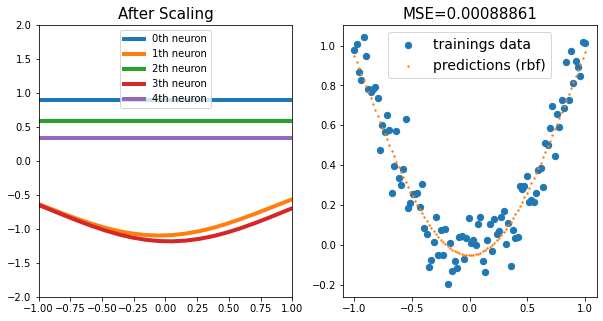

In [18]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
for i in range(num_neuron):
    interval = overlap([-1,1],bdry_rbf_on[i])
    if len(interval)!=0:
        x = np.linspace(interval[0],interval[1],20)
        plt.plot(x, [piece_rbf(weight_rbf_on,i,val) for val in x], label=str(i)+'th neuron',linewidth=4)
plt.xlim(-1,1)
plt.ylim(-2,2)
plt.title('After Scaling',fontsize=15)
plt.legend(prop={'size': 10}); 

plt.subplot(122)
preds_rbf_on = []
size = 100
for j in np.linspace(-1,1,size):
    preds_rbf_on.append(model_rbf_on.predict([j]))
p = tf.reshape(tf.constant(preds_rbf_on),len(preds_rbf_on))
error_rbf_on = tf.keras.losses.MSE(x_on1**2,p).numpy()
plt.title('MSE=%.8f'%(error_rbf_on),fontsize=15)
plt.scatter(x_on1, y_on1, s=40, label="trainings data")     #size of point
plt.scatter(np.linspace(-1,1,size), np.array(preds_rbf_on), s=2, label="predictions (rbf)")
plt.legend(prop={'size': 14});
# fig.savefig("images/NN_Neurons_on_rbf.png")

Target function - (2)

$$
y = \sin x
$$

##### Activation: ReLU

In [19]:
np.random.seed(12345)
x_on2 = np.linspace(-1,1,100) 
y_on2 = np.sin(np.pi*x_on2) + 0.1*np.random.normal(0, 1, len(x_on2)) 

In [20]:
num_neuron = 5
set_seed(12345)
model_relu_sin = tf.keras.Sequential()
model_relu_sin.add(tf.keras.layers.Dense(num_neuron,activation='relu'))
model_relu_sin.add(tf.keras.layers.Dense(1))
model_relu_sin.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_relu_sin.fit(x_on2,y_on2, epochs=1500, verbose=0)

weight_sin = model_relu_sin.get_weights()
bdry_sin = []
bdry1_sin = []
for i in range(weight_sin[0].shape[1]):
    val = -weight_sin[1][i]/weight_sin[0][0,i]
    if weight_sin[0][0,i] >0:
        bdry_sin.append((val,i))    
        bdry1_sin.append((val,i,'left'))     
    else:
        bdry_sin.append((val,i))   
        bdry1_sin.append((val,i,'right'))
        
bdry_arr_sin = np.array(sorted(bdry_sin))

def piece(weight,i,x):
    b1 = weight[1][i]
    w1 = weight[0][0,i]
    val = tf.keras.activations.relu(w1*x+b1).numpy()
    return (weight[2][i])*val

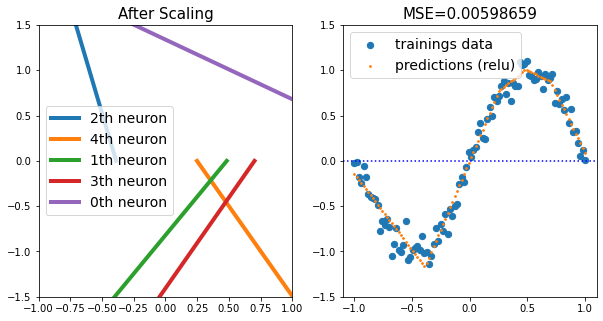

In [21]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
x_rb = 1
x_lb = -1
for i in map(int,bdry_arr_sin[:,1]):
    if bdry1_sin[i][-1] == 'left' and bdry1_sin[i][0]<x_rb: 
        x = np.linspace(bdry1_sin[i][0],x_rb,20)
        plt.plot(x, [piece(weight_sin,i,val) for val in x], label=str(i)+'th neuron', linewidth=4)
    elif bdry1_sin[i][-1] == 'right' and bdry1_sin[i][0]>x_lb:
        x = np.linspace(x_lb,bdry1_sin[i][0],20)
        plt.plot(x, [piece(weight_sin,i,val) for val in x], label=str(i)+'th neuron', linewidth=4)

plt.xlim(-1,1)
plt.ylim(-1.5,1.5)
plt.title('After Scaling',fontsize=15)
plt.legend(prop={'size': 14});


plt.subplot(122)
preds_relu_sin = []
size = 100
for j in np.linspace(-1,1,size):
    preds_relu_sin.append(model_relu_sin.predict([j]))
p = tf.reshape(tf.constant(preds_relu_sin),len(preds_relu_sin))
error = tf.keras.losses.MSE(np.sin(np.pi*x_on2),p).numpy()
plt.title('MSE=%.8f'%(error),fontsize=15)
plt.axhline(0,c='b',linestyle=':')
plt.ylim(-1.5,1.5)
plt.scatter(x_on2, y_on2, s=40, label="trainings data")     #size of point
plt.scatter(np.linspace(-1,1,size), np.array(preds_relu_sin), s=3, label="predictions (relu)")
plt.legend(prop={'size': 14});
# fig.savefig("images/NN_Neurons_on_sin_relu.png")

Target function - (2)

$$
y = \sin x
$$

##### Activation: RBF

In [22]:
set_seed(12345)
model_rbf_sin = tf.keras.Sequential()
model_rbf_sin.add(tf.keras.layers.Dense(2,activation=rbf))
model_rbf_sin.add(tf.keras.layers.Dense(1))
model_rbf_sin.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_rbf_sin.fit(x_on2,y_on2, epochs=1500, verbose=0)

weight_rbf_sin = model_rbf_sin.get_weights()
bdry_sin = []

for i in range(weight_rbf_sin[0].shape[1]):
    val1 = (-2-weight_rbf_sin[1][i])/weight_rbf_sin[0][0,i]
    val2 = (2-weight_rbf_sin[1][i])/weight_rbf_sin[0][0,i]
    bdry_sin.append((min(val1,val2),max(val1,val2)))    

def overlap(interval1,interval2):
    if max(interval1[0],interval2[0]) < min(interval1[1],interval2[1]):
        return [max(interval1[0],interval2[0]), min(interval1[1],interval2[1])]
    else:
        return []
    
def piece_rbf(weight,i,x):
    b1 = weight[1][i]
    w1 = weight[0][0,i]
    val = rbf(w1*x+b1).numpy()
    return (weight[2][i])*val

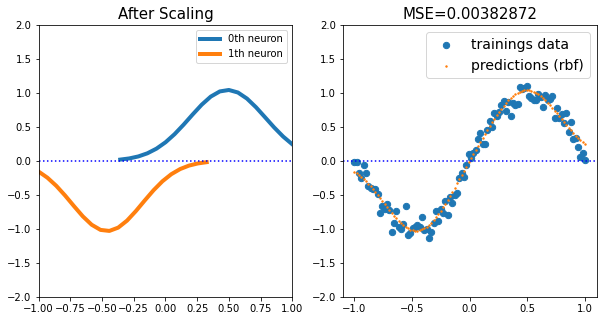

In [23]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
for i in range(2):
    interval = overlap([-1,1],bdry_sin[i])
    if len(interval)!=0:
        x = np.linspace(interval[0],interval[1],20)
        plt.plot(x, [piece_rbf(weight_rbf_sin,i,val) for val in x], label=str(i)+'th neuron',linewidth=4)
plt.xlim(-1,1)
plt.ylim(-2,2)
plt.axhline(0,c='b',linestyle=':')
plt.title('After Scaling',fontsize=15)
plt.legend(prop={'size': 10}); 

plt.subplot(122)
preds_rbf_sin = []
size = 100
for j in np.linspace(-1,1,size):
    preds_rbf_sin.append(model_rbf_sin.predict([j]))
p = tf.reshape(tf.constant(preds_rbf_sin),len(preds_rbf_sin))
error = tf.keras.losses.MSE(np.sin(np.pi*x_on2),p).numpy()
plt.title('MSE=%.8f'%(error),fontsize=15)
plt.axhline(0,c='b',linestyle=':')
plt.scatter(x_on2, y_on2, s=40, label="trainings data")     
plt.scatter(np.linspace(-1,1,size), np.array(preds_rbf_sin), s=2, label="predictions (rbf)")
plt.ylim(-2,2)
plt.legend(prop={'size': 14});
# fig.savefig("images/NN_Neurons_on_sin_rbf.png")

### Cross-validation

#### 1
$$
y = \sin x
$$

Sample size = 1000

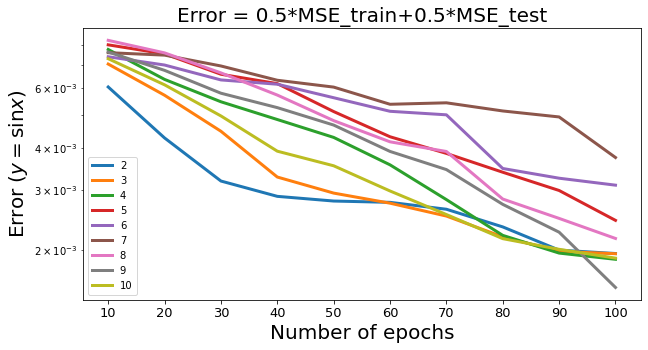

In [36]:
## Training size = 1000
epo_ls = 10*np.arange(1,11)
hid_ls = np.arange(2,11) #1 is not good
score_all = np.zeros((len(hid_ls),len(epo_ls)))
ratio = [0.5, 0.5]

for i in range(len(hid_ls)):
    filename = 'Data/sin_1%s1_split_MSE.mat'%(hid_ls[i])
    partial_data = sio.loadmat(filename)
    score_all[i] = ratio[0]*partial_data['train'] + ratio[1]*partial_data['test']    #formula to compute score

fig = plt.figure(figsize=(10,5))
for i in range(len(hid_ls)):
    plt.semilogy(epo_ls, score_all[i,:], linewidth=3, label='%d'%(hid_ls[i]))
plt.xticks(epo_ls,fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel('Number of epochs',fontsize=20)
plt.ylabel('Error ($y=\sin x$)',fontsize=20)
plt.title('Error = %.1f*MSE_train+%.1f*MSE_test'%(ratio[0],ratio[1]),fontsize=20)
plt.legend();
# fig.savefig("images/NN_sin0.png");

#### 2
$$
y = \sin x
$$

Sample size = 5000

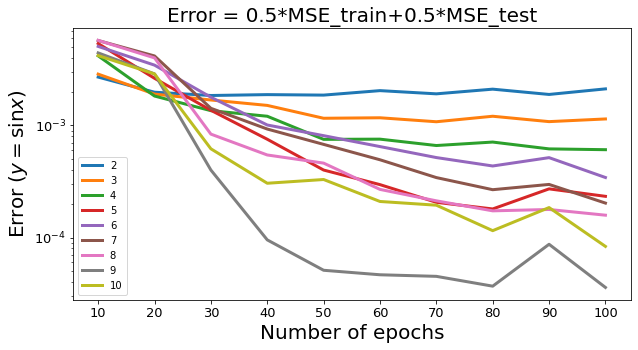

In [25]:
## Training size = 5000
epo_ls = 10*np.arange(1,11)
hid_ls = np.arange(2,11) #1 is not good
score_all = np.zeros((len(hid_ls),len(epo_ls)))
ratio = [0.5, 0.5]

for i in range(len(hid_ls)):
    filename = 'Data/sin5_1%s1_split_MSE.mat'%(hid_ls[i])
    partial_data = sio.loadmat(filename)
    score_all[i] = ratio[0]*partial_data['train'] + ratio[1]*partial_data['test']    #formula to compute score

fig = plt.figure(figsize=(10,5))
for i in range(len(hid_ls)):
    plt.semilogy(epo_ls, score_all[i,:], linewidth=3, label='%d'%(hid_ls[i]))
plt.xticks(epo_ls,fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel('Number of epochs',fontsize=20)
plt.ylabel('Error ($y=\sin x$)',fontsize=20)
plt.title('Error = %.1f*MSE_train+%.1f*MSE_test'%(ratio[0],ratio[1]),fontsize=20)
plt.legend();
# fig.savefig("images/NN_sin1.png");

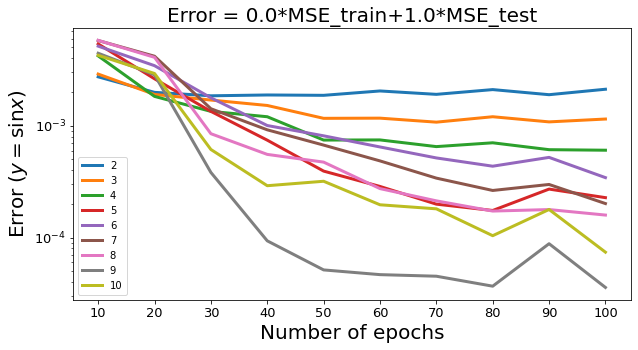

In [26]:
## Training size = 1000
epo_ls = 10*np.arange(1,11)
hid_ls = np.arange(2,11) #1 is not good
score_all = np.zeros((len(hid_ls),len(epo_ls)))
ratio = [0.0, 1.0]

for i in range(len(hid_ls)):
    filename = 'Data/sin5_1%s1_split_MSE.mat'%(hid_ls[i])
    partial_data = sio.loadmat(filename)
    score_all[i] = ratio[0]*partial_data['train'] + ratio[1]*partial_data['test']    #formula to compute score

fig = plt.figure(figsize=(10,5))
for i in range(len(hid_ls)):
    plt.semilogy(epo_ls, score_all[i,:], linewidth=3, label='%d'%(hid_ls[i]))
plt.xticks(epo_ls,fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel('Number of epochs',fontsize=20)
plt.ylabel('Error ($y=\sin x$)',fontsize=20)
plt.title('Error = %.1f*MSE_train+%.1f*MSE_test'%(ratio[0],ratio[1]),fontsize=20)
plt.legend();
# fig.savefig("images/NN_sin2.png");

#### 3
$$
y=(x+3)(x-1)^2
$$
Sample size = 1000

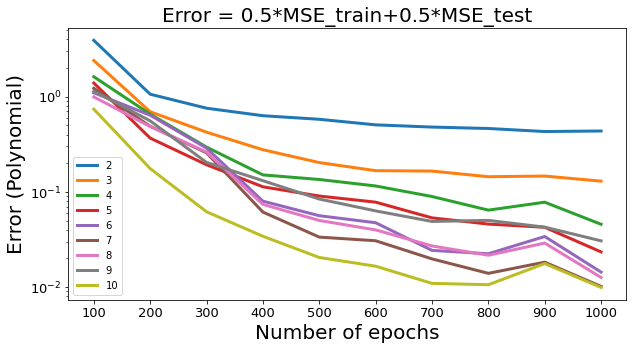

In [7]:
epo_ls = 100*np.arange(1,11)
hid_ls = np.arange(2,11) #1 is not good
score_all = np.zeros((len(hid_ls),len(epo_ls)))
ratio = [0.5, 0.5]

for i in range(len(hid_ls)):
    filename = 'Data/poly_1%s1_split_MSE.mat'%(hid_ls[i])
    partial_data = sio.loadmat(filename)
    score_all[i] = ratio[0]*partial_data['train'] + ratio[1]*partial_data['test']    #formula to compute score

fig = plt.figure(figsize=(10,5))
for i in range(len(hid_ls)):
    plt.semilogy(epo_ls, score_all[i,:], linewidth=3, label='%d'%(hid_ls[i]))
plt.xticks(epo_ls,fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel('Number of epochs',fontsize=20)
plt.ylabel('Error (Polynomial)',fontsize=20)
plt.title('Error = %.1f*MSE_train+%.1f*MSE_test'%(ratio[0],ratio[1]),fontsize=20)
plt.legend();
# fig.savefig("images/NN_poly1.png");

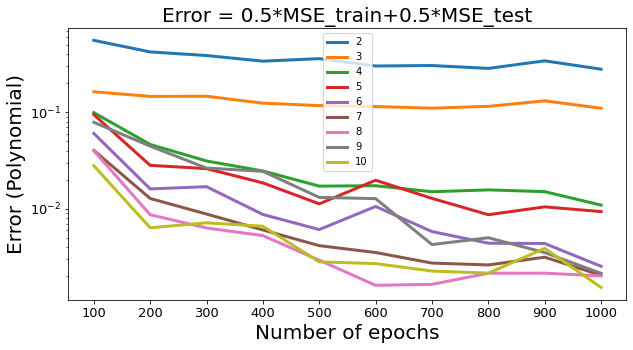

In [4]:
epo_ls = 100*np.arange(1,11)
hid_ls = np.arange(2,11) #1 is not good
score_all = np.zeros((len(hid_ls),len(epo_ls)))
ratio = [0.5, 0.5]

for i in range(len(hid_ls)):
    filename = 'Data/poly5_1%s1_split_MSE.mat'%(hid_ls[i])
    partial_data = sio.loadmat(filename)
    score_all[i] = ratio[0]*partial_data['train'] + ratio[1]*partial_data['test']    #formula to compute score

fig = plt.figure(figsize=(10,5))
for i in range(len(hid_ls)):
    plt.semilogy(epo_ls, score_all[i,:], linewidth=3, label='%d'%(hid_ls[i]))
plt.xticks(epo_ls,fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel('Number of epochs',fontsize=20)
plt.ylabel('Error (Polynomial)',fontsize=20)
plt.title('Error = %.1f*MSE_train+%.1f*MSE_test'%(ratio[0],ratio[1]),fontsize=20)
plt.legend();
# fig.savefig("images/NN_poly5.png");

## 6.3 Neural networks in a data-consistent framework

## Example

$$ \frac{dy(t)}{dt} = -\lambda y, \ \  y(0)=1 $$
$$ y(t) = e^{-\lambda t} $$
$$QoI = y(0.5)$$
$\Lambda = (-\infty, \infty)$, $\mathcal{D}=(0,\infty)$


Finite difference:
$$
\frac{y_{i+1} - y_i}{\Delta t} = -\lambda y_i
$$
so
$$
y_{i+1} = -\lambda\Delta t y_i + y_i = (1-\lambda\Delta t)y_i
$$

Define $n := \frac{0.5}{\Delta t}$, then
$$
\hat{Q}(\lambda)=y(0.5) = y_n = (1-\lambda\Delta t)^n y_0 = (1-\lambda\Delta t)^n
$$

In [29]:
def Qexact(l):
    return np.exp(-l*0.5)

np.random.seed(12345)
size = 100
delta_t = 0.01
n = int(0.5/delta_t)
lam_in = np.random.normal(0, 1, size)
y_out = np.array([(1-i*delta_t)**n for i in lam_in])

num_neuron = 5
tf.random.set_seed(12345)
model_ode = tf.keras.Sequential()
model_ode.add(tf.keras.layers.Dense(num_neuron,activation=rbf))
model_ode.add(tf.keras.layers.Dense(1))

model_ode.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_ode.fit(lam_in,y_out, epochs=1500, verbose=0)

In [30]:
preds_ode = []
size_eval_ode = 100
x_eval_ode = np.linspace(-3,3,size_eval_ode)
y_exact_ode = [np.exp(-i*0.5) for i in x_eval_ode]
for j in x_eval_ode:
    preds_ode.append(model_ode.predict([j]))

In [31]:
preds_ode_shaped = tf.reshape(tf.constant(np.array(preds_ode)),len(preds_ode))
error_ode = tf.keras.losses.MSE(y_exact_ode,preds_ode_shaped).numpy()
error_ode

0.009232481

### Forward

In [32]:
#Build $\pi_D^Q$ and $\pi_D^{Qhat}$, use 1000 samples
N_kde = int(1E3)

np.random.seed(12345)
init_sample = np.random.normal(size = N_kde)
pfinit_sample = Qexact(init_sample)
pfinit_dens = kde(pfinit_sample)  #pf_exact
NN_sample = []
for j in init_sample:
    NN_sample.append(model_ode.predict([j])[0,0])
NN_dens = kde(NN_sample)    #pf_approx

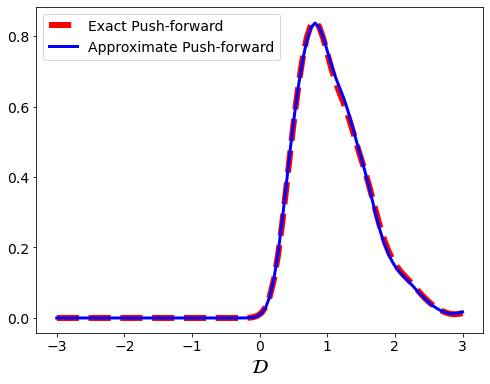

In [33]:
fig = plt.figure(figsize=(8,6))
x = np.linspace(-3,3,100)
plt.plot(x,pfinit_dens(x),'--',linewidth=6,color='r',label='Exact Push-forward')
plt.plot(x,NN_dens(x),linewidth=3,color='b',label='Approximate Push-forward')   
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.xlabel('$\mathcal{D}$', fontsize=20)
plt.legend(prop={'size': 14});
# fig.savefig('images/NN_forward.png');

### Inverse

In [34]:
## Uncomment the following to generate updated samples
# N_inv = int(1E4)

# ## Use true samples to get obs dens
# exact_sample = beta.rvs(2, 5, loc=0, scale=1, size=N_inv, random_state=12345)
# pfexact_sample = Qexact(exact_sample)
# obs_dens = kde(pfexact_sample)

# ## exact and approx pf of initial dens
# np.random.seed(12345)
# init_sample_inv = np.random.normal(size=N_inv)
# NN_sample = []
# for j in init_sample_inv:
#     NN_sample.append(model_ode.predict([j])[0,0])
# NN_dens = kde(NN_sample)   ## approx pf

# ## updated sample using rejection sampling
# r = np.array([obs_dens(i)/NN_dens(i) for i in NN_sample]).flatten()
# M = max(r)
# np.random.seed(12345)
# unif = np.random.uniform(size=len(r))
# idx = list(M*unif < r)
# up_sample = init_sample_inv[idx]
# np.savetxt("Data/up_sample.dat",up_sample)

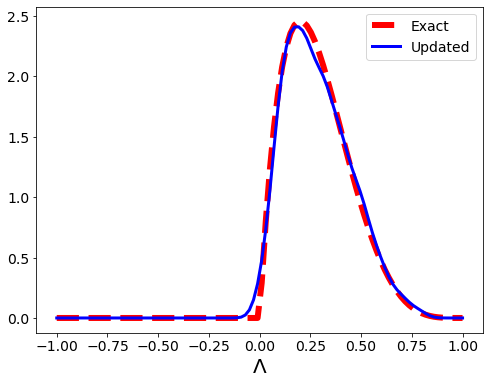

In [35]:
up_sample = np.loadtxt("Data/up_sample.dat")
up_dens = kde(up_sample)

fig = plt.figure(figsize=(8,6))
size = 100
x = np.linspace(-1,1,size)
plt.plot(x,beta.pdf(x, 2, 5, loc=0, scale=1),'--',linewidth=6,color='r',label='Exact')
plt.plot(x,up_dens(x),linewidth=3,color='b',label='Updated')   
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.xlabel('$\Lambda$', fontsize=20)
plt.legend(prop={'size': 14});
# fig.savefig('images/NN_inverse.png');